# ARN - PW3

Auteurs : Rémi Ançay & Lucas Charbonnier

In [124]:
import pandas as pd

# chargement des données

data_folder = "../data/lab3/"

mouse_data_1 = pd.read_csv(data_folder + "EEG_mouse_data_1.csv")
mouse_data_2 = pd.read_csv(data_folder + "EEG_mouse_data_2.csv")

mouse_data = pd.concat([mouse_data_1, mouse_data_2])

test_data = pd.read_csv(data_folder + "EEG_mouse_data_test.csv")

In [125]:
# sélection des features qui seront gardées
from itertools import chain

print(len(mouse_data.columns))

def discard_unwanted_frequencies(dataframe):
    discarded_frequencies = range(26,102) #chain(range(16, 45),range(55,102))
    for freq in discarded_frequencies:
        col_name = "amplitude_around_" + str(freq) + "_Hertz"
        dataframe = dataframe.drop(columns=col_name)
    return dataframe

mouse_data = discard_unwanted_frequencies(mouse_data)
test_data = discard_unwanted_frequencies(test_data)

# we now have 26 columns : 25 features (frequencies) and 1 result column
print(len(mouse_data.columns))

102
26


In [126]:
#affiche le nombre de chaque state
print(mouse_data["state"].value_counts())

state
w    24360
n    13664
r     2839
Name: count, dtype: int64


In [127]:
from sklearn.preprocessing import StandardScaler

# normalisation du dataset
scaler = StandardScaler()
mouse_data.iloc[:,1:] = scaler.fit_transform(mouse_data.iloc[:,1:])
test_data.iloc[:,1:] = scaler.fit_transform(test_data.iloc[:,1:])

In [128]:
#!pip install keras
#!pip install tensorflow

In [129]:
import keras
from keras import layers
from sklearn.model_selection import KFold

# creations de folds pour la validation croisée

N_FOLDS = 3

keras.utils.set_random_seed(123)
kf = KFold(n_splits=N_FOLDS, shuffle=True)

# taille totale et taille des folds
for i,(train_index, test_index) in enumerate(kf.split(mouse_data)):
    print(train_index, test_index)

[    0     2     3 ... 40860 40861 40862] [    1     8    15 ... 40854 40856 40857]
[    0     1     4 ... 40859 40860 40862] [    2     3     5 ... 40855 40858 40861]
[    1     2     3 ... 40857 40858 40861] [    0     4     6 ... 40859 40860 40862]


In [130]:
# Création du modèle
def create_model_two_classes():
    MODEL_LAYERS = [2]
    ACTIVATION_FCTN = "sigmoid"
    LEARNING_RATE = 0.01
    MOMENTUM = 0.9

    layers = [keras.Input((25,))]
    for layer in MODEL_LAYERS:
            layers.append(keras.layers.Dense(layer, activation=ACTIVATION_FCTN))
    layers.append(keras.layers.Dense(1,activation=ACTIVATION_FCTN))

    mlp = keras.Sequential(layers)

    mlp.compile(
        optimizer=keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM),
        loss="mse"
    )
    return mlp

model = create_model_two_classes()

model.summary()

Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_92 (Dense)                │ (None, 2)              │            52 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55 (220.00 B)

 Trainable params: 55 (220.00 B)

 Non-trainable params: 0 (0.00 B)

In [131]:
def train_model(model_creation_func, input_dataset ,output_dataset):
    history_list = []
    trained_mlp = []

    for i,(train_idx, test_idx) in enumerate(kf.split(mouse_data)) :
        mlp = model_creation_func()
        history = mlp.fit(
            x=input_dataset.iloc[train_idx], y=output_dataset.iloc[train_idx],
            validation_data=(input_dataset.iloc[test_idx], output_dataset.iloc[test_idx]),
            epochs=50
        )

        history_list.append(history)
        trained_mlp.append(mlp)
    return history_list, trained_mlp, train_idx, test_idx

In [132]:
# Preparation des données pour l'entrainement
input_data = mouse_data.drop(columns='state')
output_data_two_classes = mouse_data['state']

output_data_two_classes = output_data_two_classes.replace('w', 0)
output_data_two_classes = output_data_two_classes.replace('n', 1)
output_data_two_classes = output_data_two_classes.replace('r', 1)

In [133]:
# Entrainement du modèle
history_list_two_classes, trained_mlp_two_classes, train_idx_two_classes, test_idx_two_classes = train_model(create_model_two_classes, input_data, output_data_two_classes)

Epoch 1/50


852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 840us/step - loss: 0.2172 - val_loss: 0.1095
Epoch 2/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step - loss: 0.1043 - val_loss: 0.0898
Epoch 3/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 805us/step - loss: 0.0917 - val_loss: 0.0870
Epoch 4/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 723us/step - loss: 0.0894 - val_loss: 0.0864
Epoch 5/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 760us/step - loss: 0.0888 - val_loss: 0.0863
Epoch 6/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 723us/step - loss: 0.0885 - val_loss: 0.0862
Epoch 7/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 743us/step - loss: 0.0884 - val_loss: 0.0862
Epoch 8/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 779us/step - loss: 0.0883 - val_loss: 0.0862
Epoch 9/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 725us/step - loss: 0.0882 - val_loss: 0.0861
Epoch 10/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 784us/step - loss: 0.0882 - val_loss: 0.0860
Epoch 11/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 774us/step - loss: 0.0881 - val_loss: 0.0860
Epoch 12/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 

In [134]:
import numpy as np
import matplotlib.pyplot as pl

def plot_history(history_list):
    train_losses = np.array([history.history['loss'] for history in history_list])
    val_losses = np.array([history.history['val_loss'] for history in history_list])

    # Calculate mean and standard deviation for training and validation losses
    mean_train_loss = np.mean(train_losses, axis=0)
    std_train_loss = np.std(train_losses, axis=0)
    mean_val_loss = np.mean(val_losses, axis=0)
    std_val_loss = np.std(val_losses, axis=0)

    # Plot mean and standard deviation for training loss
    pl.plot(mean_train_loss, label='Training Loss (Mean)')
    pl.fill_between(range(len(mean_train_loss)), mean_train_loss - std_train_loss, mean_train_loss + std_train_loss, alpha=0.3, label='Training Loss (Std)')

    # Plot mean and standard deviation for validation loss
    pl.plot(mean_val_loss, label='Validation Loss (Mean)')
    pl.fill_between(range(len(mean_val_loss)), mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, alpha=0.3, label='Validation Loss (Std)')

    # Add labels and legend
    pl.xlabel('Epochs')
    pl.ylabel('Loss')
    pl.legend()

    # Display the plot
    pl.show()

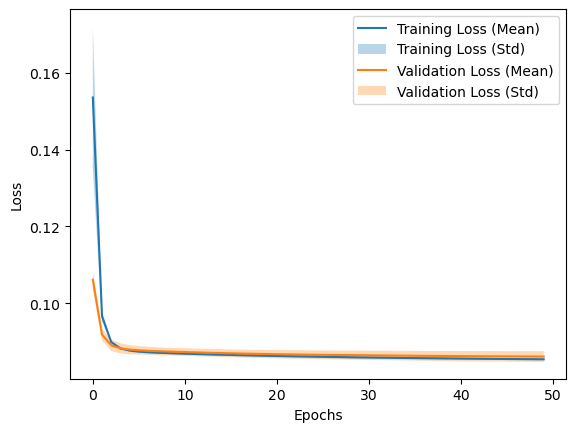

In [135]:
plot_history(history_list_two_classes)


Après avoir testé plusieurs hyper-paramètres (nombre de couches, neurones par couche, fonction d'activation), nous avons trouvé qu'utiliser un sigmoïde avec une seule hidden-layer de 3 neurones donnait les meilleures résultats.

426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step


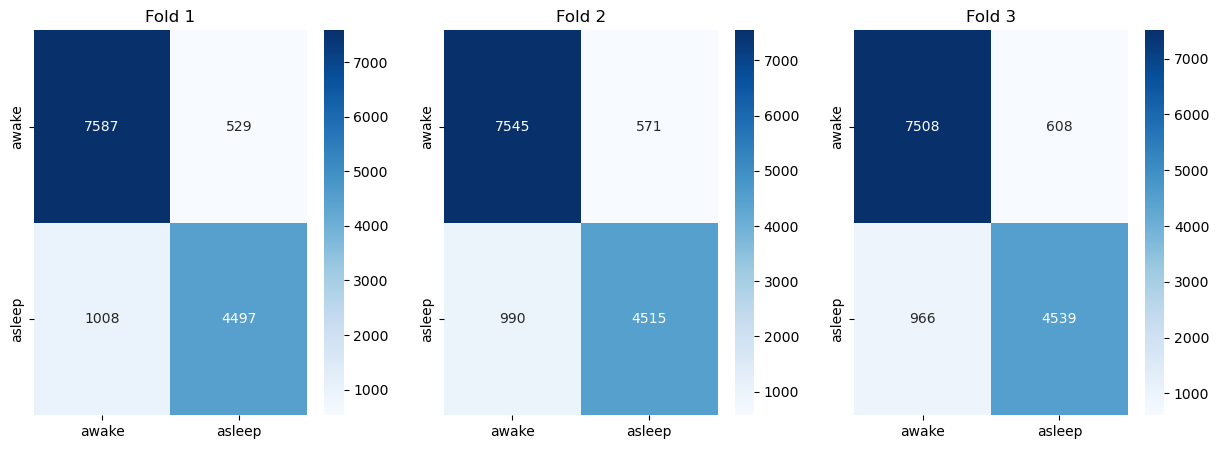

426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step


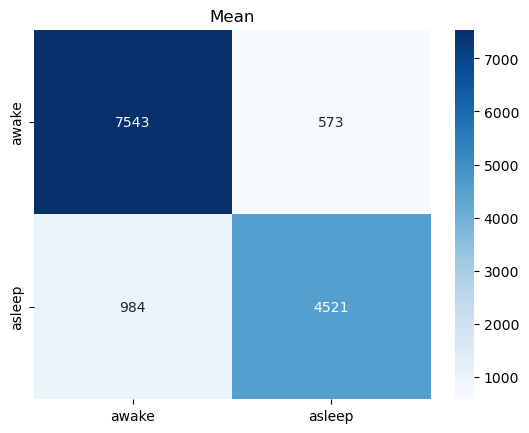

In [136]:
#plot all the confusion matrices and the mean confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

#show confusion matrices on kfold subplots
fig, axs = pl.subplots(1, N_FOLDS, figsize=(15, 5))
for i, mlp in enumerate(trained_mlp_two_classes):
    y_pred = mlp.predict(input_data.iloc[test_idx_two_classes])
    y_pred = np.round(y_pred)
    cm = confusion_matrix(output_data_two_classes.iloc[test_idx_two_classes], y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["awake", "asleep"], yticklabels=["awake", "asleep"], ax=axs[i])
    axs[i].set_title(f'Fold {i+1}')
pl.show()

#show mean confusion matrix
y_pred = np.mean([mlp.predict(input_data.iloc[test_idx_two_classes]) for mlp in trained_mlp_two_classes], axis=0)
y_pred = np.round(y_pred)
cm = confusion_matrix(output_data_two_classes.iloc[test_idx_two_classes], y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["awake", "asleep"], yticklabels=["awake", "asleep"])
pl.title('Mean')
pl.show()

In [137]:
#F1 score
from sklearn.metrics import f1_score

f1_scores = []

for i, mlp in enumerate(trained_mlp_two_classes):
    y_pred = mlp.predict(input_data.iloc[test_idx_two_classes])
    y_pred = np.round(y_pred)
    f1 = f1_score(output_data_two_classes.iloc[test_idx_two_classes], y_pred)
    f1_scores.append(f1)

mean_f1 = np.mean(f1_scores)

print(f1_scores)
print("F1 score moyen : ", mean_f1)

426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step
[0.854049947773241, 0.85261070720423, 0.8522343221930154]
F1 score moyen :  0.8529649923901621


# Part 2 : 3 classes detection

In [138]:
#Input date will be the same as before (input_data)

#We need to one hot encode the output data
output_data_three_classes = pd.get_dummies(mouse_data['state'])

In [139]:
output_data_three_classes.head() 

,n,r,w
0,True,False,False
1,True,False,False
2,True,False,False
3,False,False,True
4,False,False,True


In [140]:
# Création du modèle
def create_model_three_classes():
    MODEL_LAYERS = [2]
    ACTIVATION_FCTN = "sigmoid"
    LEARNING_RATE = 0.01
    MOMENTUM = 0.9

    layers = [keras.Input((25,))]
    for layer in MODEL_LAYERS:
            layers.append(keras.layers.Dense(layer, activation=ACTIVATION_FCTN))
    layers.append(keras.layers.Dense(3,activation="softmax"))

    mlp = keras.Sequential(layers)

    mlp.compile(
        optimizer=keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM),
        loss="mse"
    )
    return mlp

model_three_classes = create_model_three_classes()

model_three_classes.summary()

Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_100 (Dense)               │ (None, 2)              │            52 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 3)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61 (244.00 B)

 Trainable params: 61 (244.00 B)

 Non-trainable params: 0 (0.00 B)

In [141]:
# Entrainement du modèle
history_list_three_classes, trained_mlp_three_classes, train_idx_three_classes, test_idx_three_classes = train_model(create_model_three_classes, input_data, output_data_three_classes)

Epoch 1/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 991us/step - loss: 0.1514 - val_loss: 0.0934
Epoch 2/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 863us/step - loss: 0.0895 - val_loss: 0.0801
Epoch 3/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 934us/step - loss: 0.0799 - val_loss: 0.0771
Epoch 4/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 888us/step - loss: 0.0773 - val_loss: 0.0758
Epoch 5/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 813us/step - loss: 0.0760 - val_loss: 0.0749
Epoch 6/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 783us/step - loss: 0.0750 - val_loss: 0.0739
Epoch 7/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 892us/step - loss: 0.0739 - val_loss: 0.0729
Epoch 8/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 967us/step - loss: 0.0728 - val_loss: 0.0719
Epoch 9/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 907us/step - loss: 0.0717 - val_loss: 0.0710
Epoch 10/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 886us/step - loss: 0.0707 - val_loss: 0.0702
Epoch 11/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 958us/step - loss: 0.0699 - val_loss: 0.0695
Epoch 12/50
852/852 ━━━━━━━━━━

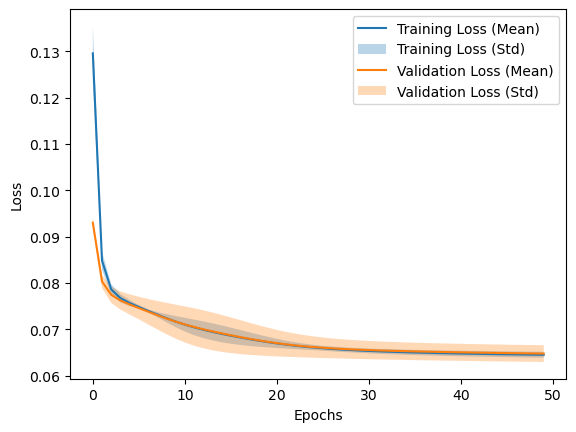

In [142]:
plot_history(history_list_three_classes)

In [143]:
#change the output data to be the one hot encoded one

output_data_three_classes = output_data_three_classes.idxmax(axis=1)

output_data_three_classes = output_data_three_classes.replace('n', 0)
output_data_three_classes = output_data_three_classes.replace('r', 1)
output_data_three_classes = output_data_three_classes.replace('w', 2)



426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step
[0 2 2 ... 0 2 0]
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step
[0 2 2 ... 0 2 0]
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step
[0 2 2 ... 0 2 0]


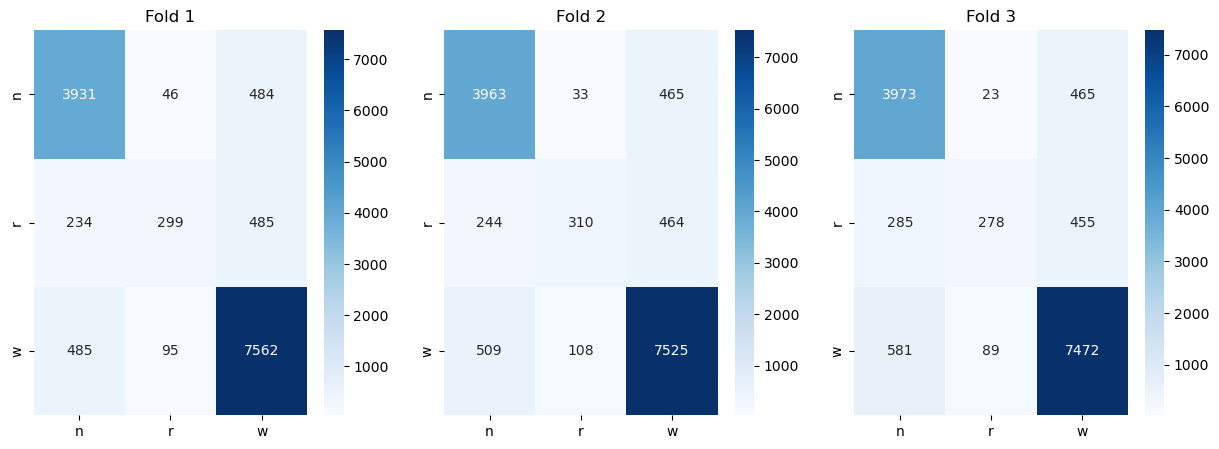

426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step


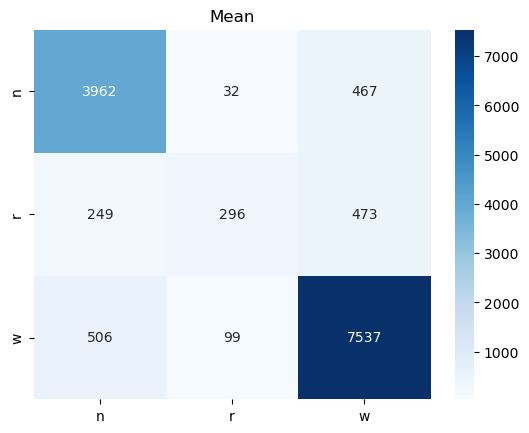

In [144]:
#plot all the confusion matrices and the mean confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

#show confusion matrices on kfold subplots
fig, axs = pl.subplots(1, N_FOLDS, figsize=(15, 5))
for i, mlp in enumerate(trained_mlp_three_classes):
    y_pred = mlp.predict(input_data.iloc[test_idx_three_classes])
    y_pred = np.round(y_pred)
    y_pred = y_pred.argmax(axis=1)
    print(y_pred)
    cm = confusion_matrix(output_data_three_classes.iloc[test_idx_three_classes], y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["n", "r", "w"], yticklabels=["n", "r", "w"], ax=axs[i])
    axs[i].set_title(f'Fold {i+1}')
pl.show()

#show mean confusion matrix
y_pred = np.mean([mlp.predict(input_data.iloc[test_idx_three_classes]) for mlp in trained_mlp_three_classes], axis=0)
y_pred = np.round(y_pred)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(output_data_three_classes.iloc[test_idx_three_classes], y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["n", "r", "w"], yticklabels=["n", "r", "w"])
pl.title('Mean')
pl.show()

In [145]:
#F1 score
f1_scores = []

for i, mlp in enumerate(trained_mlp_three_classes):
    y_pred = mlp.predict(input_data.iloc[test_idx_three_classes])
    y_pred = np.round(y_pred)
    y_pred = y_pred.argmax(axis=1)
    f1 = f1_score(output_data_three_classes.iloc[test_idx_three_classes], y_pred, average='micro')
    f1_scores.append(f1)

mean_f1 = np.mean(f1_scores)

print(f1_scores)
print("F1 score moyen : ", mean_f1)

426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step
[0.8657220468394391, 0.8661625431319286, 0.8606563394758094]
F1 score moyen :  0.8641803098157257


# Competition

ici nous allons refaire la même chose que dans la dernière partie mais en changant la loss function pour une categorical_crossentropy

In [159]:
# Création du modèle
def create_model_three_classes_competition():
    MODEL_LAYERS = [2]
    ACTIVATION_FCTN = "sigmoid"
    LEARNING_RATE = 0.01
    MOMENTUM = 0.9

    layers = [keras.Input((25,))]
    for layer in MODEL_LAYERS:
            layers.append(keras.layers.Dense(layer, activation=ACTIVATION_FCTN))
    layers.append(keras.layers.Dense(3,activation="softmax"))

    mlp = keras.Sequential(layers)

    mlp.compile(
        optimizer=keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM),
        loss="categorical_crossentropy"
    )
    return mlp

model_three_classes = create_model_three_classes()

model_three_classes.summary()

Model: "sequential_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_120 (Dense)               │ (None, 2)              │            52 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (None, 3)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61 (244.00 B)

 Trainable params: 61 (244.00 B)

 Non-trainable params: 0 (0.00 B)

In [166]:
#Usilisation de ACP pour réduire la dimensionnalité
from sklearn.decomposition import PCA

full_data_without_state = pd.concat([mouse_data_1, mouse_data_2]).drop(columns='state')

pca = PCA(n_components=25)
pca.fit(full_data_without_state)

input_data = pca.transform(full_data_without_state)

input_data = pd.DataFrame(input_data)

#We need to one hot encode the output data
output_data_three_classes_competition = pd.get_dummies(mouse_data['state'])

AttributeError: 'DataFrame' object has no attribute 'concat'

In [161]:
#Entrainement du modèle
history_list_three_classes_competition, trained_mlp_three_classes_competition, train_idx_three_classes_competition, test_idx_three_classes_competition = train_model(create_model_three_classes_competition, input_data, output_data_three_classes_competition)

Epoch 1/50


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 1), output.shape=(None, 3)

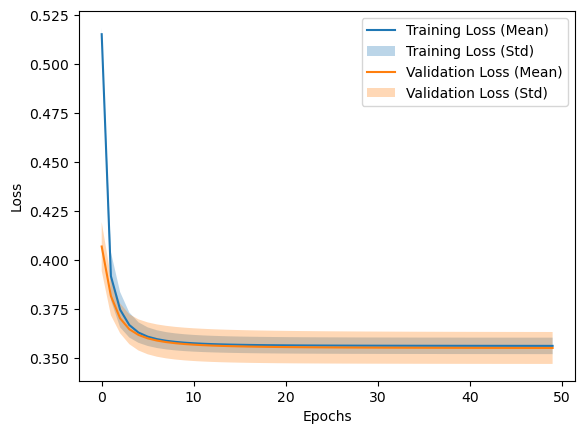

In [162]:
plot_history(history_list_three_classes_competition)

In [163]:
#change the output data to be the one hot encoded one

output_data_three_classes_competition = output_data_three_classes_competition.idxmax(axis=1)

output_data_three_classes_competition = output_data_three_classes_competition.replace('n', 0)
output_data_three_classes_competition = output_data_three_classes_competition.replace('r', 1)
output_data_three_classes_competition = output_data_three_classes_competition.replace('w', 2)

ValueError: No axis named 1 for object type Series

426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step
[0 2 0 ... 2 2 0]
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step
[0 2 0 ... 2 2 0]
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step
[0 2 0 ... 2 2 0]


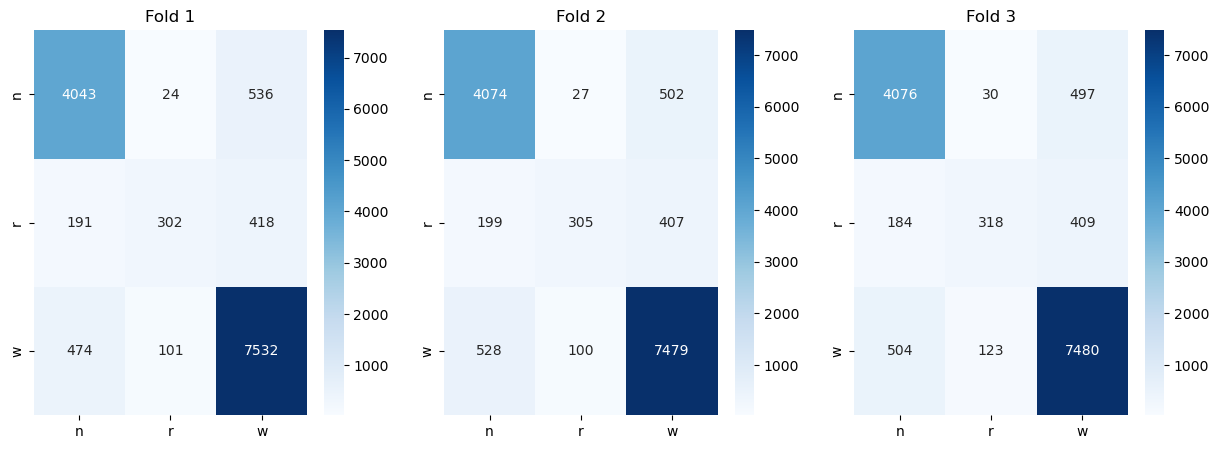

426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step


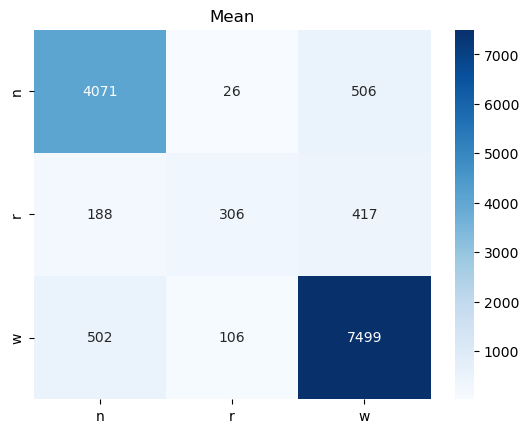

In [164]:
#plot all the confusion matrices and the mean confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

#show confusion matrices on kfold subplots
fig, axs = pl.subplots(1, N_FOLDS, figsize=(15, 5))
for i, mlp in enumerate(trained_mlp_three_classes_competition):
    y_pred = mlp.predict(input_data.iloc[test_idx_three_classes_competition])
    y_pred = np.round(y_pred)
    y_pred = y_pred.argmax(axis=1)
    print(y_pred)
    cm = confusion_matrix(output_data_three_classes_competition.iloc[test_idx_three_classes_competition], y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["n", "r", "w"], yticklabels=["n", "r", "w"], ax=axs[i])
    axs[i].set_title(f'Fold {i+1}')
pl.show()

#show mean confusion matrix
y_pred = np.mean([mlp.predict(input_data.iloc[test_idx_three_classes_competition]) for mlp in trained_mlp_three_classes_competition], axis=0)

y_pred = np.round(y_pred)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(output_data_three_classes_competition.iloc[test_idx_three_classes_competition], y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["n", "r", "w"], yticklabels=["n", "r", "w"])
pl.title('Mean')
pl.show()


In [165]:

#F1 score
f1_scores = []

for i, mlp in enumerate(trained_mlp_three_classes_competition):
    y_pred = mlp.predict(input_data.iloc[test_idx_three_classes_competition])
    y_pred = np.round(y_pred)
    y_pred = y_pred.argmax(axis=1)
    f1 = f1_score(output_data_three_classes_competition.iloc[test_idx_three_classes_competition], y_pred, average='micro')
    f1_scores.append(f1)

mean_f1 = np.mean(f1_scores)

print(f1_scores)
print("F1 score moyen : ", mean_f1)

426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
[0.871962410983041, 0.870567506056824, 0.8717421628367962]
F1 score moyen :  0.8714240266255536
